In [19]:
import pandas as pd
import rfm
import seaborn as sns

In [20]:
# Настройка графиков
sns.set(
    font_scale=1.3, 
    style='whitegrid', 
    rc={'figure.figsize': (10, 6)}
)

### Загрузка данных

In [21]:
df = pd.read_csv('purchases.csv')

In [22]:
df.head()

,customer_unique_id,order_id,order_approved_at,product_id,price
0,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,4aa6014eceb682077f9dc4bffebc05b0,289.00
1,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,bd07b66896d6f1494f5b86251848ced7,139.94
2,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,a5647c44af977b148e0a3a4751a09e2e,149.94
3,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,9391a573abe00141c56e38d84d7d5b3b,230.00
4,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,0be701e03657109a8a4d5168122777fb,259.90


In [23]:
df.dtypes

customer_unique_id     object
order_id               object
order_approved_at      object
product_id             object
price                 float64
dtype: object

In [24]:
df.order_approved_at = pd.to_datetime(df.order_approved_at)

In [25]:
df.dtypes

customer_unique_id            object
order_id                      object
order_approved_at     datetime64[ns]
product_id                    object
price                        float64
dtype: object

### RFM anaslysis

Единица покупки - заказ

In [26]:
df = (
    df
    .groupby(['customer_unique_id', 'order_id', 'order_approved_at'], as_index=False)
    .price.sum()
)

In [27]:
df.head()

,customer_unique_id,order_id,order_approved_at,price
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 11:11:18,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 18:25:44,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:49:17,25.99
3,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 20:06:52,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,3e470077b690ea3e3d501cffb5e0c499,2018-04-05 19:48:59,154.00


In [28]:
df.shape

(74498, 4)

Текущая дата

In [29]:
now = df['order_approved_at'].max() + pd.Timedelta(days=1)
now

Timestamp('2018-08-30 15:10:26')

df с колонками recency, frequency, monetary

In [30]:
rfm_df = rfm.get_rfm_values(
    df=df,
    unit_id='customer_unique_id',
    money='price',
    time='order_approved_at',
    now=now,
    time_horizon=365
)
rfm_df

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,146,1,154.00
...,...,...,...,...
72519,fffa431dd3fcdefea4b1777d114144f2,303,1,64.99
72520,fffb09418989a0dbff854a28163e47c6,254,1,58.00
72521,fffbf87b7a1a6fa8b03f081c5f51a201,245,1,149.00
72522,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89


_Оценка rfm параметров_

In [31]:
max_score = 3  # Максимальная оценка для rmf-анализа

In [32]:
rfm_df = rfm.get_rfm_score(
    df=rfm_df,
    score_column='recency',
    score_name='r',
    max_score=max_score,
    add_score_bins=True
)

{'bins_for_scores': {'1': '[226.0, 364]',
                     '2': '[118.0, 226.0]',
                     '3': '[1, 118.0]'}}


In [33]:
rfm_df = rfm.get_rfm_score(
    df=rfm_df,
    score_column='frequency',
    score_name='f',
    max_score=max_score,
    add_score_bins=True,
    auto_max_score_adjust=True
)

AUTO ADJUSTMENT max_score=3 -> 2
{'bins_for_scores': {'1': '[1, 1.0]', '2': '[1.0, 11]'}}


In [34]:
rfm_df = rfm.get_rfm_score(
    df=rfm_df,
    score_column='monetary',
    score_name='m',
    max_score=max_score,
    add_score_bins=True,
    auto_max_score_adjust=True
)

{'bins_for_scores': {'1': '[0.85, 58.67]',
                     '2': '[58.67, 128.8]',
                     '3': '[128.8, 13440.0]'}}


In [35]:
rfm_df = rfm.get_rfm_agg(
    df=rfm_df,
    unit_id='customer_unique_id',
    use_bins=True
)

In [36]:
rfm_df

,rfm,r_bin,f_bin,m_bin,amount
0,323,"[1, 118.0]","[1.0, 11]","[128.8, 13440.0]",486
1,322,"[1, 118.0]","[1.0, 11]","[58.67, 128.8]",167
2,321,"[1, 118.0]","[1.0, 11]","[0.85, 58.67]",48
3,313,"[1, 118.0]","[1, 1.0]","[128.8, 13440.0]",7637
4,312,"[1, 118.0]","[1, 1.0]","[58.67, 128.8]",8075
5,311,"[1, 118.0]","[1, 1.0]","[0.85, 58.67]",8031
6,223,"[118.0, 226.0]","[1.0, 11]","[128.8, 13440.0]",461
7,222,"[118.0, 226.0]","[1.0, 11]","[58.67, 128.8]",153
8,221,"[118.0, 226.0]","[1.0, 11]","[0.85, 58.67]",41
9,213,"[118.0, 226.0]","[1, 1.0]","[128.8, 13440.0]",7666


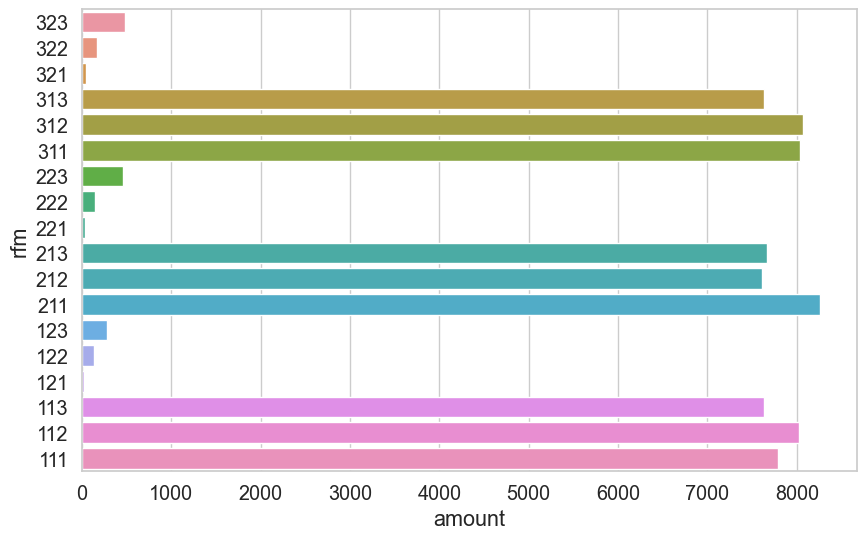

In [37]:
sns.barplot(data=rfm_df, x='amount', y='rfm');

#### Выводы
- Основной сегмент пользователей - пользователи с низкой частотой покупок
- Это и основная проблема
  - \*Это не новые пользователи, поскольку данные собраны за достаточно большой временной период, на котором почти все пользователи делали лишь одну покупку
- Возможно, это связано со спецификой магазина (специфичные товары, которые достаточно купить один раз на большой временной промежуток + розничная торговля)
- Или, возможно, это связано с неэффективным маркетингом
- Необходимо как-то увеличивать retention

_Расшифровка сегментов пользователей_

In [38]:
segment_map = {
    r'111':         'худшие',
    r'11[2-3]':     'не поняли ценность продукта',
    r'1[2-3][1-3]': 'нужно вернуть',
    r'21[1-3]':     'не поняли ценность продукта (есть шанс?)',
    r'2[2][1-3]':   'хорошие (напомнить/стимулировать?)',
    r'31[1-3]':     'новички',
    r'32[1-2]':     'хорошие (увеличить средний чек?)',
    r'323':         'лучшие'
    
}
rfm_df.assign(segment=rfm_df.rfm.replace(segment_map, regex=True))

,rfm,r_bin,f_bin,m_bin,amount,segment
0,323,"[1, 118.0]","[1.0, 11]","[128.8, 13440.0]",486,лучшие
1,322,"[1, 118.0]","[1.0, 11]","[58.67, 128.8]",167,хорошие (увеличить средний чек?)
2,321,"[1, 118.0]","[1.0, 11]","[0.85, 58.67]",48,хорошие (увеличить средний чек?)
3,313,"[1, 118.0]","[1, 1.0]","[128.8, 13440.0]",7637,новички
4,312,"[1, 118.0]","[1, 1.0]","[58.67, 128.8]",8075,новички
5,311,"[1, 118.0]","[1, 1.0]","[0.85, 58.67]",8031,новички
6,223,"[118.0, 226.0]","[1.0, 11]","[128.8, 13440.0]",461,хорошие (напомнить/стимулировать?)
7,222,"[118.0, 226.0]","[1.0, 11]","[58.67, 128.8]",153,хорошие (напомнить/стимулировать?)
8,221,"[118.0, 226.0]","[1.0, 11]","[0.85, 58.67]",41,хорошие (напомнить/стимулировать?)
9,213,"[118.0, 226.0]","[1, 1.0]","[128.8, 13440.0]",7666,не поняли ценность продукта (есть шанс?)


Inspired by: KCM6

### Идеи по улучшению:
- добавить возможность вручную вводить диапазоны bins и соответствующие им оценки